<a href="https://colab.research.google.com/github/overfatih/TDDI_2024/blob/main/sentiment_analysis_turkish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install transformers

In [39]:
import numpy as np
import re
import nltk
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
stopWords = set(stopwords.words('turkish'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
import seaborn as sns
from sklearn.utils import class_weight
import matplotlib
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import random
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report
from spacy.tokenizer import Tokenizer
from spacy.lang.tr import Turkish
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [26]:
df = pd.read_csv('/content/drive/MyDrive/ai/datasets/magaza_yorumlari_duygu_analizi.csv', encoding= 'utf-16')
df.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   11426 non-null  object
 1   Durum   11429 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


In [28]:
## null olan veriler kaldırılıyor
df = df.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11426 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   11426 non-null  object
 1   Durum   11426 non-null  object
dtypes: object(2)
memory usage: 267.8+ KB


In [30]:
df = df.rename({'Görüş': 'review'}, axis=1)
df = df.rename({'Durum': 'status'}, axis=1)

In [31]:
df.head()

,review,status
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


In [32]:
df.columns

Index(['review', 'status'], dtype='object')

In [33]:
df["status"].value_counts()

,count
status,
Olumlu,4252
Olumsuz,4237
Tarafsız,2937


status
Olumlu      4252
Olumsuz     4237
Tarafsız    2937
Name: count, dtype: int64


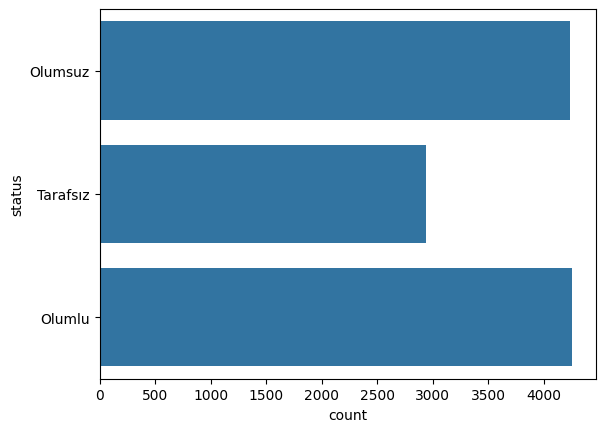

In [34]:
sns.countplot(df["status"])
print(df.status.value_counts())

In [35]:
df['status'] = df.loc[:, 'status'].map({'Olumlu' : 2, 'Olumsuz' : 0 , 'Tarafsız' : 1})

In [36]:
positive_df= df.loc[df['status'] == 2]
notr_df= df.loc[df['status'] == 1]
negative_df= df.loc[df['status'] == 0]

positive_df = positive_df.sample(n=500)
negative_df = negative_df.sample(n=500)
notr_df = notr_df.sample(n=500)
df = pd.concat([positive_df, negative_df, notr_df])
df = df.sample(frac=1).reset_index(drop=True)
df

,review,status
0,Ürün kalitesi fiyatıyla kıyaslandığında hiç te...,2
1,Ürün güzel şık özellikle rengi çok hoş kaba du...,2
2,Tüm ihtiyaçlarınızı gören bi makine ... Fiyat ...,2
3,"İşimi gördü, çekim gücü beklediğimden düşük am...",1
4,berbat bir urun kesinlikle tavsiye etmiyorum f...,0
...,...,...
1495,Güzel bir ürün kaliteli,2
1496,cok tessekürler,2
1497,türk kahvesi ucuz ve güzel bir cezveyle de çok...,2
1498,"Resimler aynı değil, resimde gösterilen tepesi...",0


In [40]:
def pre_processing(text):
    text = text.lower()  #Büyük harften -Küçük harfe çevirme
    #text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text
    text = text.replace('[^\w\s]', '')
    ## sayılar silinsin
    text = text.replace('\d', '')
    text=nltk.word_tokenize(text) # splits the words that are in the sentence from each other.
    text =[word for word in text if not word in set(stopwords.words("turkish"))]
    # sentences < 500
    #if len(text) > 500:
    #  text = text[:500]
    #kelime kokunu bulma

    # WordNetLemmatizer'ı tanımlayın
    lemma = WordNetLemmatizer()
    # Her kelimeyi lemmatize et
    lemmatized_text = [lemma.lemmatize(word) for word in text]
    #lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text] # this code finds the root of the word for a word in the sentence and change them to their root form.
    text=" ".join(text)
    return text

In [41]:
df["review"]=df["review"].apply(lambda x: pre_processing(x))

In [ ]:
#device = 'cuda'

In [42]:
def filter(text):
  final_text = ''
  for word in text.split():
    if word.startswith('@'):
      continue
    elif word[:-3] in ['com', 'org']:
      continue
    elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
      continue
    else:
      final_text += word + ' '
  return final_text

In [43]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/740M [00:00<?, ?B/s]

In [44]:
def feature_extraction(text):
  tokens = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
  input_ids = tokens['input_ids']
  attention_mask = tokens['attention_mask']
  x = tokenizer.encode(filter(text))
  with torch.no_grad():
    outputs = bert(input_ids, attention_mask=attention_mask)
  x = outputs.last_hidden_state
  return list(x[0][0].cpu().numpy())

In [45]:
## train test split
from sklearn.model_selection import train_test_split, cross_val_score

train_set, test_set = train_test_split(df,random_state=42,test_size=0.2)
print(train_set.shape, test_set.shape)

(1200, 2) (300, 2)


In [46]:
train_set.head()

,review,status
382,ürün fiyat performansı iyi değildi .,0
538,kargo şirketinde mi sıkıntı sizde mi sıkıntı a...,0
1493,almak isteyenler düşünmeden alabilir hız ayarı...,2
1112,önce kull.buharli ütü altından alışmaya başlan...,2
324,önce buradan tefal 500 wat ütü aldım 5 yıl kul...,1


In [47]:
print(train_set['review'][1111])

biçaklar kisa bi̇r sürede aşiri isiniyor


In [50]:
X_train = []
y_train = []
for element in tqdm(train_set.index):
    X_train.append(feature_extraction(train_set['review'][element]))
    y_train.append(train_set['status'][element])

X_test = []
y_test = []

for element in tqdm(test_set.index):
    X_test.append(feature_extraction(test_set['review'][element]))
    y_test.append(test_set['status'][element])

100%|██████████| 300/300 [10:10<00:00,  2.03s/it]


In [ ]:
print(X_test[0])

['l']


In [51]:
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, activation='tanh', solver='adam', alpha=1e-5, learning_rate='constant',
                      verbose=1, early_stopping=True)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

Iteration 1, loss = 1.34818656
Validation score: 0.433333
Iteration 2, loss = 1.07782782
Validation score: 0.533333
Iteration 3, loss = 0.95227469
Validation score: 0.491667
Iteration 4, loss = 0.89891096
Validation score: 0.616667
Iteration 5, loss = 0.84608792
Validation score: 0.583333
Iteration 6, loss = 0.79648268
Validation score: 0.508333
Iteration 7, loss = 0.74616523
Validation score: 0.591667
Iteration 8, loss = 0.71138060
Validation score: 0.550000
Iteration 9, loss = 0.68253920
Validation score: 0.575000
Iteration 10, loss = 0.65238421
Validation score: 0.525000
Iteration 11, loss = 0.63001051
Validation score: 0.566667
Iteration 12, loss = 0.60392355
Validation score: 0.575000
Iteration 13, loss = 0.58404050
Validation score: 0.566667
Iteration 14, loss = 0.56128422
Validation score: 0.575000
Iteration 15, loss = 0.53080195
Validation score: 0.575000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    reca

In [55]:
import pickle

# Modeli kaydetme
with open('profplay_tddi_model.pkl', 'wb') as file:
    pickle.dump(model, file)